# TO DO: 
- Fix the link lengths!!! Need to do this in GIS. Remote desktop in? That's my best bet. 

# Running the NetworkSedimentTransporter from a shapefile of a river network

<img align="right" style="margin:0 0 20px 20px" width="25%" height="25%" src="https://csdms.colorado.edu/csdms_wiki/images/OpenEarthscape_logo.png">

*Allison Pfeiffer (pfeiffa@wwu.edu) May 2025*

This tutorial illustrates how to model the transport of coarse sediment through a river network loaded from shapefiles using the [NetworkSedimentTransporter Landlab component](https://joss.theoj.org/papers/10.21105/joss.02341). This notebook is a condensed example of many of the [Landlab tutorials associated with the NetworkSedimentTransporter](https://landlab.csdms.io/generated/tutorials/index.html).

This notebook is intended to follow the *Flume Example* notebook, and aims to minimize duplication of the information therein. 

In this example we will: 
- create a *Landlab grid* from loaded point and polyline shapefiles
- create *sediment “parcels”* to mimic a natural gravel bedded river
- run the component 
- plot the results of the model run

First, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import xarray as xr

from landlab.io import read_shapefile

from landlab.components import (
    FlowDirectorSteepest,
    NetworkSedimentTransporter,
    BedParcelInitializerDepth,
)

from landlab.grid.network import NetworkModelGrid

from landlab.io import esri_ascii, read_esri_ascii
from landlab.plot.graph import plot_links, plot_nodes
from landlab.plot.imshow import imshow_grid
from landlab.plot import graph, plot_network_and_parcels

OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1

### Creating a river network grid
The first thing we'll do is create a landlab `NetworkModelGrid` from two shapefiles of a tiny little basin: one containing **points** at the node locations (populated with elevation and drainage area data), and the other containing **polylines** representing the links (populated with channel slope, reach length and drainage area data). 

Doing this for a basin of your own? A starting guideline is to create links that are relatively consistent length, editing the network as needed to ensure that no links are much smaller than others. Very small links will have very small active layer volumes, and may be prone to runaway aggradation if transport capacity is slightly lower than the upstream links. 

For a small, simple river network, these shapefiles are easy to create yourself in GIS from a DEM. However, for a larger one this would become cumbersome. You have two good options for streamlining this process: 
1. Scott David (USU) and colleagues at Utah State have created a set of tools for extracting a river network and all the attributes you'd like from a DEM [(USUAL Watershed Tools, David et al., 2023)](https://www.sciencedirect.com/science/article/abs/pii/S1364815222002766).
2. Shelby Ahrendt (USGS) and Eric Hutton (CSDMS) have created a much simpler, though somewhat more limited tool, to create a network model grid from a DEM in just a few lines of code. [This landlab tutorial XXXXXX](XXXXXXX) notebook explains its use.  

In [8]:
# Create Network Model Grid from shapefile
link_shapefile = os.path.join(os.getcwd (), ("hugo_links6.shp"))
points_shapefile = os.path.join(os.getcwd(), ("hugo_nodes.shp"))

grid = read_shapefile(
    link_shapefile,
    points_shapefile = points_shapefile,
    node_fields = ["Elev_m", "DArea_m2"],
    link_fields = ["Chan_slope", "length_m","DA_aprx_m2"],
    link_field_conversion = {"Chan_slope":"channel_slope", "length_m":"reach_length","DA_aprx_m2":"drainage_area"}, # maps from shapefile field names to standard landlab variables ## 
    node_field_conversion = {"DArea_m2": "drainage_area", "Elev_m": "topographic__elevation"},
    threshold = 10,
    )

grid.at_node["topographic__elevation"]=grid.at_node["topographic__elevation"].astype(float)
grid.at_node["bedrock__elevation"] = grid.at_node["topographic__elevation"].copy()

# For plotting later, we'll read in the DEM as a raster model grid
rm_grid, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rm_grid.status_at_node[rm_grid.nodes_at_right_edge] = rm_grid.BC_NODE_IS_FIXED_VALUE
rm_grid.status_at_node[np.isclose(z, -9999.0)] = rm_grid.BC_NODE_IS_CLOSED

/var/folders/cd/x37_ch550zgdjf18w4krrs840000gp/T/ipykernel_86606/1120124108.py:19: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rm_grid, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


Here is a is a simplified view of the topology of our network model grid, labeled with the link and node indices:

<Axes: xlabel='x', ylabel='y'>

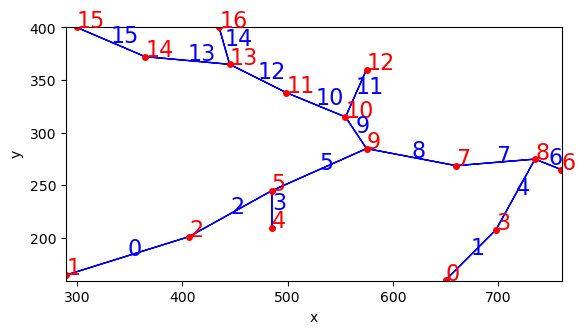

In [9]:
graph.plot_graph(grid, at="node,link")

Note that the indexing will not match the ordering of the shapefile IDs. Landlab re-orders the links/nodes spatially, starting with the grid element at the lower left and working up. See [this Landlab tutorial](https://landlab.csdms.io/tutorials/grids/diverse_grid_classes.html) for more details. 

### Assign variables based on hydraulic geometry scaling

Because our shapefiles didn't contain width and flow depth data, we'll use downstream hydraulic geometry scaling relationships to estimate these and assign them to the grid. 

In [10]:
# Approximately Scott Creek, CA hydraulic geometry relations 

grid.at_link["channel_width"] = 0.0028 * (grid.at_link['drainage_area'])**(0.49)# m

grid.at_link["flow_depth"] = 0.008 * (grid.at_link['drainage_area'])**(0.32)# m

### Check grid for reasonable characteristics

*Reminder: check your network for physically reasonable geometry!* 

Because the `NetworkSedimentTransporter` calculates transport based on reach averaged shear stress calculated based on a simple depth-slope product, we should have links that are longer than the backwater lengthscale (see XXXXX Paola and Morig, 1996). We can check that before moving on. 

In [11]:
backwater_lengthscale = grid.at_link["flow_depth"]/grid.at_link["channel_slope"]

if np.any(grid.at_link["reach_length"]<backwater_lengthscale): 
    print('warning: links are shorter than the backwater lengthscale')
else: 
    print('All links are longer than their backwater lengthscale. Good.')

All links are longer than their backwater lengthscale. Good.


Now we make parcels

In [14]:
initialize_parcels = BedParcelInitializerDepth(grid,
                                          flow_depth_at_link = grid.at_link["flow_depth"],
                                          tau_c_50=0.045,
                                          tau_c_multiplier = 2.8, # high mobility channel
                                          median_number_of_starting_parcels= 100,
                                          extra_parcel_attributes = ['some_attribute']
                                          )
parcels = initialize_parcels()

#parcels.dataset['some_attribute'].values = np.full(parcels.number_of_items, "boring")
#parcels.dataset['some_attribute'].values[99]= "special_one"

In [15]:
# code block inspecting parcels -- D50, min/max, parcel volume
D50 = parcels.calc_aggregate_value(xr.Dataset.median, "D", at="link", fill_value=0.0) 

print(D50)

[0.07221158 0.08939919 0.08990142 0.12143271 0.01285703 0.02403108
 0.05535256 0.06734787 0.03387988 0.19591588 0.09151097 0.05768351
 0.05907795 0.05078374 0.06543431 0.04650672]


/opt/anaconda3/envs/general/lib/python3.13/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension element_id because variable element_id is not a coordinate. To create an index for element_id, please first call `.set_coords('element_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


### Run the NST

This time, we'll keep it simple, running the NST in its simplest configuration for just 10 timesteps. 

In [16]:
# set up and run the flow director
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

# initialize the NST
nst = NetworkSedimentTransporter(
    grid,
    parcels,
    fd,
    active_layer_method = "Constant10cm",
)

timesteps = 10
dt = 60*60*24 # seconds

for t in range(0, (timesteps*dt), dt):

    nst.run_one_step(dt)


### Plot the results in map form

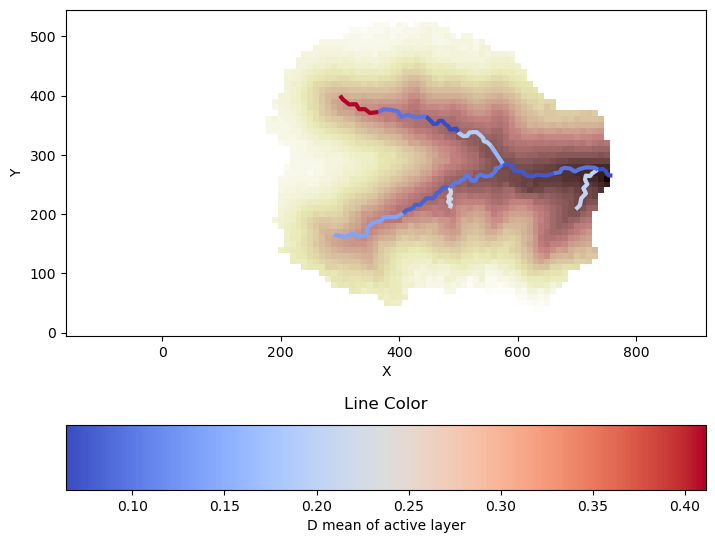

In [19]:
plt.figure("DEM_and_Network")

imshow_grid(
    rm_grid,
    "topographic__elevation",
    color_for_closed=None,
    allow_colorbar=False,
)

plot_network_and_parcels(
    grid,
    parcels,
    link_attribute=nst.d_mean_active,
    parcel_alpha=0, # For now, we'll just look at the network
    network_linewidth= 3,
    link_attribute_title= "D mean of active layer",
    network_cmap= "coolwarm",
    fig=plt.figure("DEM_and_Network"),
    )

### Query particular parcels

Below is an example of a more complicated example: filtering to only consider the last timestep status of the parcels that originated on a particular link of interest. 

In [ ]:
timestep_of_interest = -1
originating_link = 15 

# filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(parcels.dataset.element_id, dtype=bool)
parcelfilter[:, timestep_of_interest] = (
    parcels.dataset.element_id[:, 0] == originating_link
)

vol_orig_link = parcels.calc_aggregate_value(
    xr.Dataset.sum, "volume", at="link", filter_array=parcelfilter, fill_value=0.0
)

fig = plot_network_and_parcels(
    grid,
    parcels,
    
    # Color links by the volume of sed in last timestep that originated on our link of interest
    link_attribute=vol_orig_link,
    link_attribute_title="Vol of sed originating on link x",
    network_linewidth=10,
    network_cmap='copper_r',

    # Plot the location of each parcel that originated on that link
    parcel_filter=parcelfilter[:,-1],
    parcel_alpha=1.0,
    parcel_color_attribute="D",
    parcel_size = 15,
    parcel_color_norm=colors.LogNorm(vmin=0.01, vmax=1),
    parcel_color_cmap = 'bone_r'
)

### Other plots to visualize results

In [ ]:
plt.plot(grid.at_link["channel_slope"], nst.d_mean_active, ".")
plt.xlabel("Channel slope (m/m)")
plt.ylabel("Mean grain size of active layer (m)")

In [ ]:
plt.loglog(parcels.dataset.D[:, -1], nst._distance_traveled_cumulative, ".")
plt.xlabel("Parcel grain size (m)")
plt.ylabel("Cumulative parcel travel distance (m)")

# Note: some of the smallest grain travel distances can exceed the length of the
# grid by "overshooting" during a single timestep of high transport rate

# Excited to explore and develop the NST? 
The posibilities are endless! There is so much that can be done. 

### Wish list: 
- memory savers! simple option to occasionally dump early parcels timestep records from xarray dataset (every 500 timesteps?) to file
- modify landlab utilities like `flow__distance` to work on network model grid
- modify NST to allow for automatic stress partitioning based on active layer grain size

### In progress: 
- modify to use D50 in Wilcock and Crowe equations (Ask Allison)
- add Gilbert and Wilcox (2024) sediment transport equations (Ask Fatemeh)

### Acknowledgements: 
Development of the Landlab NetworkSedimentTransporter and this clinic was supported by NSF grants [GLD 2138504](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2138504&utm_medium=email&utm_source=govdelivery) and [CSSI 2104055](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2104055&HistoricalAwards=false).

Thanks to Mark Piper, Eric Hutton, and Jon Czuba for technical and scientific assistance. 